In [ ]:
import tensorflow as tf
import numpy as np

# 1. Load and Prepare MNIST Data
def load_mnist():
    """Loads and preprocesses the MNIST dataset."""
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Normalize pixel values to [0, 1]
    x_train = x_train.astype("float32") / 255.0
    
    x_test = x_test.astype("float32") / 255.0

    # Reshape to (batch_size, height, width, channels)
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
    x_test = np.expand_dims(x_test, axis=-1)    # Add channel dimension

    # Convert labels to one-hot encoding
    y_train = tf.one_hot(y_train, depth=10)
    y_test = tf.one_hot(y_test, depth=10)

    return x_train, y_train, x_test, y_test

2024-12-21 08:39:07.711700: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-21 08:39:11.542756: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-21 08:39:11.543016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-21 08:39:11.921681: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 08:39:12.961602: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-21 08:39:12.966807: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
# 2. Define Model Parameters
LEARNING_RATE = 0.001
BATCH_SIZE = 128
EPOCHS = 10
INPUT_SHAPE = (28, 28, 1)  # MNIST input image shape
NUM_CLASSES = 10  # 10 Digits 0-9


# 3. Create TensorFlow Variables for Weights and Biases
def initialize_weights_and_biases():
    """Initializes the weights and biases for the CNN."""

    # Convolutional Layer 1: 32 filters of size 3x3
    W_conv1 = tf.Variable(tf.random.normal([3, 3, 1, 32], stddev=0.1))  # (height, width, input channels, output channels)
    b_conv1 = tf.Variable(tf.random.normal([32], stddev=0.1))

    # Convolutional Layer 2: 64 filters of size 3x3
    W_conv2 = tf.Variable(tf.random.normal([3, 3, 32, 64], stddev=0.1))
    b_conv2 = tf.Variable(tf.random.normal([64], stddev=0.1))

    # Fully Connected Layer 1:
    # Flattened output of the convolutional layers -> 128 neurons
    W_fc1 = tf.Variable(tf.random.normal([7 * 7 * 64, 128], stddev=0.1))  # after pooling, size becomes 7x7x64
    b_fc1 = tf.Variable(tf.random.normal([128], stddev=0.1))

    # Fully Connected Layer 2 (Output Layer) : 128 neurons -> 10 classes
    W_fc2 = tf.Variable(tf.random.normal([128, NUM_CLASSES], stddev=0.1))
    b_fc2 = tf.Variable(tf.random.normal([NUM_CLASSES], stddev=0.1))

    return W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2

In [ ]:
# 4. Define the CNN Model
def cnn_model(x, W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2):
    """Defines the CNN architecture."""

    # Convolutional Layer 1 with ReLU activation, max pool
    conv1 = tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding="SAME")  # padding SAME to keep same height and width
    conv1 = tf.nn.bias_add(conv1, b_conv1)
    conv1 = tf.nn.relu(conv1)
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")  # Pooling reduces dimension

    # Convolutional Layer 2 with ReLU activation, max pool
    conv2 = tf.nn.conv2d(pool1, W_conv2, strides=[1, 1, 1, 1], padding="SAME")
    conv2 = tf.nn.bias_add(conv2, b_conv2)
    conv2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

    # Flatten the output of pool2
    flat_out = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Fully Connected Layer 1 (dense layer) with ReLU activation
    fc1 = tf.matmul(flat_out, W_fc1) + b_fc1
    fc1 = tf.nn.relu(fc1)

    # Fully Connected Layer 2 (Output Layer)
    out = tf.matmul(fc1, W_fc2) + b_fc2

    return out


In [ ]:
# 5. Define Loss Function, Optimizer, and Accuracy
def loss_function(logits, labels):
    """Defines the cross-entropy loss."""
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))



In [ ]:
def accuracy(logits, labels):
    """Calculates the accuracy."""
    predictions = tf.argmax(logits, 1)
    true_labels = tf.argmax(labels, 1)
    correct_predictions = tf.equal(predictions, true_labels)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))



In [ ]:
# 6. Training Loop
def train(x_train, y_train, x_test, y_test, W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2):
    """Train the model and evaluate it."""
    num_batches = len(x_train) // BATCH_SIZE

    for epoch in range(EPOCHS):
        for batch in range(num_batches):
            batch_x = x_train[batch * BATCH_SIZE : (batch + 1) * BATCH_SIZE]
            batch_y = y_train[batch * BATCH_SIZE : (batch + 1) * BATCH_SIZE]

            # Calculate loss and apply gradients
            with tf.GradientTape() as tape:
                logits = cnn_model(batch_x, W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2)
                loss = loss_function(logits, batch_y)

            # Apply gradients
            grads = tape.gradient(loss, [W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2])
            tf.optimizers.Adam(learning_rate=LEARNING_RATE).apply_gradients(zip(grads, [W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2]))

        # Evaluate on validation set after each epoch
        logits = cnn_model(x_test, W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2)
        acc = accuracy(logits, y_test)
        print(f"Epoch: {epoch+1}/{EPOCHS}, Validation Accuracy: {acc:.4f}")



In [ ]:
# 7. Test the Model (Evaluation on Test Set)
def test_model(x_test, y_test, W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2):
    """Evaluates the model on the test dataset."""
    logits = cnn_model(x_test, W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2)
    acc = accuracy(logits, y_test)
    print(f"Test Accuracy: {acc:.4f}")


# --- Main Execution ----
if __name__ == "__main__":
    # Load and preprocess data
    x_train, y_train, x_test, y_test = load_mnist()

    # Initialize model parameters
    W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2 = initialize_weights_and_biases()

    # Train the model
    train(x_train, y_train, x_test, y_test, W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2)

    # Test the model after training
    test_model(x_test, y_test, W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2)


Epoch: 1/10, Validation Accuracy: 0.9669
Epoch: 2/10, Validation Accuracy: 0.9810
Epoch: 3/10, Validation Accuracy: 0.9837
Epoch: 4/10, Validation Accuracy: 0.9831
Epoch: 5/10, Validation Accuracy: 0.9841
Epoch: 6/10, Validation Accuracy: 0.9840
Epoch: 7/10, Validation Accuracy: 0.9869
Epoch: 8/10, Validation Accuracy: 0.9861
Epoch: 9/10, Validation Accuracy: 0.9883
Epoch: 10/10, Validation Accuracy: 0.9892
Test Accuracy: 0.9892


In [ ]:
from google.colab import files

# Upload an image
uploaded = files.upload()

# The image file will be saved in the Colab environment
# Check the uploaded file's name
image_path = list(uploaded.keys())[0]
print(f"Uploaded image path: {image_path}")


Saving images.png to images.png
Uploaded image path: images.png


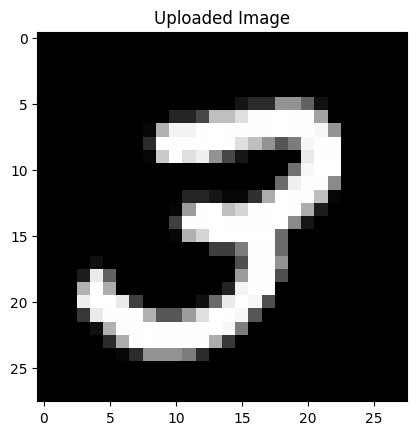

Predicted digit: 3


In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to preprocess and predict the image
def predict_image(image_path, W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2):
    # Load the image and convert it to grayscale
    img = image.load_img(image_path, target_size=(28, 28), color_mode='grayscale')

    # Convert the image to a numpy array and normalize it
    img_array = image.img_to_array(img) / 255.0  # Normalize the image to [0, 1]

    # Expand dimensions to match the input shape of the model (batch_size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)  # Shape becomes (1, 28, 28, 1)

    # Make predictions using the model
    logits = cnn_model(img_array, W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2)

    # Get the predicted class
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]

    return predicted_class

# Visualize the uploaded image
img = image.load_img("images.png", target_size=(28, 28), color_mode='grayscale')
plt.imshow(img, cmap="gray")
plt.title("Uploaded Image")
plt.show()

# Make a prediction for the uploaded image
predicted_digit = predict_image("images.png", W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2)
print(f"Predicted digit: {predicted_digit}")
